In [1]:
import requests
import json
import numpy as np
import pandas as pd
import nltk 
import matplotlib
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import re
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

In [2]:
url = 'https://newsapi.org/v2/everything?'
api_key = "c31d9f572e5d47eeaae9d16463d0c921"

In [18]:
# for downloading the lexicon
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alexander.paskal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexander.paskal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
def get_articles(file):
    '''
    This is a helper function the extract articles from the newsapi dataset
    ''' 


    article_results = [] 
    for i in range(len(file)):
        article_dict = {}
        article_dict['title'] = file[i]['title']
        article_dict['author'] = file[i]['author']
        article_dict['source'] = file[i]['source']
        article_dict['description'] = file[i]['description']
        article_dict['content'] = file[i]['content']
        article_dict['pub_date'] = file[i]['publishedAt']
        article_dict['url'] = file[i]["url"]
        article_dict['photo_url'] = file[i]['urlToImage']
        article_results.append(article_dict)
    return article_results

def get_news_articles(source: str, topic: str):
    '''
    Returns the dataframe from newsource and topic
    Input: str,str
    Output: pd frame
    '''

    assert isinstance(source,str)
    assert isinstance(topic,str)

    
    parameters_headlines = {
    'q': topic,
    'sortBy':'popularity',
    'pageSize': 100,
    'apiKey': api_key,
    'language': 'en',
    'domains' : format(source)  
    }

    # making the API call 
    response_headline = requests.get(url, params = parameters_headlines)
    response_json_headline = response_headline.json()
    responses = response_json_headline["articles"]
    # transforminf the data from JSON dictionary to a pandas data frame
    news_articles_df = pd.DataFrame(get_articles(responses))
    # printing the head to check the format and the working of the get_articles function
    return news_articles_df

In [4]:
cnn_covidf = get_news_articles("cnn.com","covid")     #cnn covid frame
fox_covidf = get_news_articles("foxnews.com","covid") #fox covid frame

In [5]:
def get_senti_frame(frame = None, download = False):

    '''
    Returns a dataframe with sentiment scores extracted using nltk vader
    Input: pd frame, bool
    Output: pd frame
    '''
    
    assert isinstance(download,bool)

    from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
    if(download):nltk.download('vader_lexicon')
    sia = SIA()
    results = []
    titles = frame["title"]

    for line in titles:
        pol_score = sia.polarity_scores(line)
        pol_score['headline'] = line
        results.append(pol_score)
    
    df = pd.DataFrame.from_records(results)
    df['label'] = 0
    df.loc[df['compound'] > 0.2, 'label'] = 1
    df.loc[df['compound'] < -0.2, 'label'] = -1
    return df

In [8]:
cnn_sframe = get_senti_frame(cnn_covidf,False)
fox_sframe = get_senti_frame(fox_covidf,False)

Here we show the processed sentiment dataframe, where 0 represents neutral, -1 represents negative, and 1 represents postive. Sentiment were calculated based on the headlines of the news

In [9]:
cnn_sframe.head()

,neg,neu,pos,compound,headline,label
0,0.169,0.390,0.442,0.6369,Indian homegrown Covid-19 shot wins WHO emerge...,1
1,0.000,1.000,0.000,0.0000,Conservative radio host says he wanted to catc...,0
2,0.000,0.729,0.271,0.3818,Opinion: How to protect pregnant people from C...,1
3,0.000,0.847,0.153,0.4023,"Even if they get breakthrough infections, vacc...",1
4,0.000,0.842,0.158,0.4939,Federal judge allows health care workers in Ne...,1


Next, we show some samples of the postively labeled  ande negative sentiment headlines

In [10]:
positive_cnn = cnn_sframe[cnn_sframe["label"] == 1]["headline"]
print(positive_cnn.iloc[0])
print(positive_cnn.iloc[2])
print(positive_cnn.iloc[5])

Indian homegrown Covid-19 shot wins WHO emergency use approval
Even if they get breakthrough infections, vaccinated people don't get as sick with Covid-19, studies show
Opinion: Alabama's use of Covid relief funds to build prisons must be stopped


In [11]:
positive_cnn = cnn_sframe[cnn_sframe["label"] == -1]["headline"]
print(positive_cnn.iloc[0])
print(positive_cnn.iloc[2])
print(positive_cnn.iloc[5])

Fired Washington State head football coach to file lawsuit over 'unjust and unlawful' termination
Opinion: Texas governor's blatant hypocrisy puts lives at risk
In pictures: Colin Powell's funeral


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot(df,title:str):
    '''
      Given a sentiment frame, plot the sentiment
    '''
  
    assert isinstance(title,str)

    fig, ax = plt.subplots(figsize=(8, 8))

    counts = df.label.value_counts(normalize=True) * 100

    sns.barplot(x=counts.index, y=counts, ax=ax)

    ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
    ax.set_ylabel("Percentage")
    ax.set_title(title)
    plt.show()


Bad key "text.kerning_factor" on line 4 in
C:\Users\alexander.paskal\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


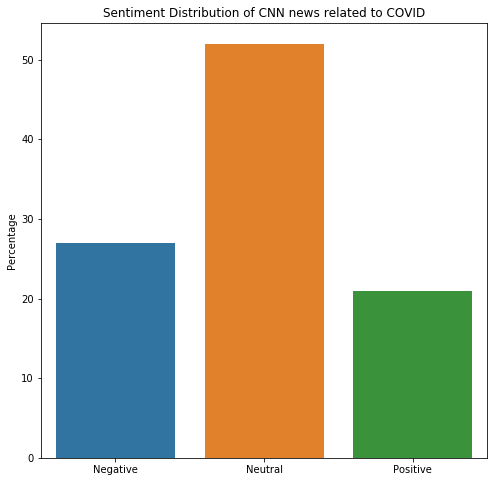

In [13]:
plot(cnn_sframe,"Sentiment Distribution of CNN news related to COVID")

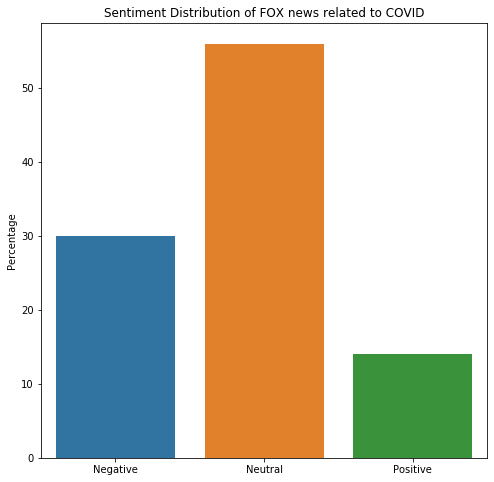

In [14]:
plot(fox_sframe,"Sentiment Distribution of FOX news related to COVID")

In [15]:
def get_word_freq(sframe,label,topk = 20,download = False):
    '''
    Returns the top words in the headlines given the label{1(pos), -1(negative)}
    Input: data frame,data frame, int, int, bool
          sframe: sentiment frame, df: news dataframe
    Output: list of dict 
    '''

    assert isinstance(label,int)
    assert isinstance(download,bool)

    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize, RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    if download: nltk.download('stopwords')

    stop_words = stopwords.words('english')
    tokens = []


    pos_lines = list(sframe[sframe.label == label].headline)

    for line in pos_lines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    pos_freq = nltk.FreqDist(tokens)
    return pos_freq.most_common(topk) if topk is not None else pos_freq.most_common()

    

In [19]:
cnn_pos = get_word_freq(cnn_sframe,label = 1, topk = None)
print(cnn_pos[:20])
cnn_neg = get_word_freq(cnn_sframe,label = -1, topk = None)
print(cnn_neg[:20])

[('covid', 8), ('19', 5), ('vaccinated', 5), ('get', 3), ('new', 3), ('us', 3), ('use', 2), ('opinion', 2), ('people', 2), ('even', 2), ('show', 2), ('vaccine', 2), ('mandate', 2), ('travel', 2), ('travelers', 2), ('era', 2), ('year', 2), ('indian', 1), ('homegrown', 1), ('shot', 1)]
[('covid', 7), ('19', 5), ('china', 3), ('washington', 2), ('state', 2), ('head', 2), ('football', 2), ('coach', 2), ('opinion', 2), ('texas', 2), ('new', 2), ('robert', 2), ('durst', 2), ('murder', 2), ('us', 2), ('america', 2), ('supply', 2), ('homicide', 2), ('charges', 2), ('bolsonaro', 2)]


In [20]:
fox_pos = get_word_freq(fox_sframe,label = 1, topk = None)
print(cnn_pos[:20])
fox_neg = get_word_freq(fox_sframe,label = -1, topk = None)
print(cnn_neg[:20])

[('covid', 8), ('19', 5), ('vaccinated', 5), ('get', 3), ('new', 3), ('us', 3), ('use', 2), ('opinion', 2), ('people', 2), ('even', 2), ('show', 2), ('vaccine', 2), ('mandate', 2), ('travel', 2), ('travelers', 2), ('era', 2), ('year', 2), ('indian', 1), ('homegrown', 1), ('shot', 1)]
[('covid', 7), ('19', 5), ('china', 3), ('washington', 2), ('state', 2), ('head', 2), ('football', 2), ('coach', 2), ('opinion', 2), ('texas', 2), ('new', 2), ('robert', 2), ('durst', 2), ('murder', 2), ('us', 2), ('america', 2), ('supply', 2), ('homicide', 2), ('charges', 2), ('bolsonaro', 2)]


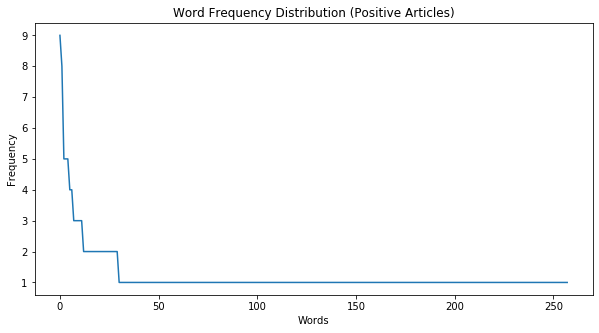

In [21]:
positive = sorted(fox_pos + cnn_pos,key = lambda i: -i[1])
y_val = [x[1] for x in positive]
fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive Articles)")
plt.show()

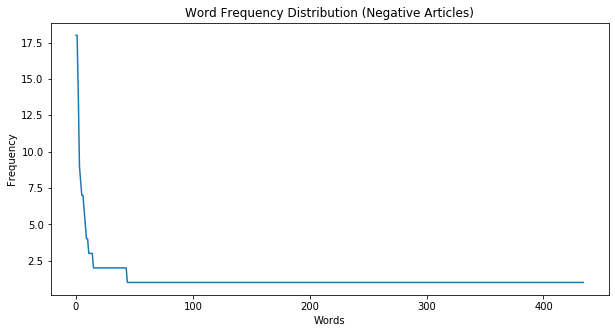

In [22]:
negative =sorted(fox_neg + cnn_neg,key = lambda i: -i[1])
y_val = [x[1] for x in negative]
fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative Articles)")
plt.show()